In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams["figure.figsize"] = (4,4)
mpl.rcParams["axes.grid"] = False

Visualizing Gini Impurity for a Binary Dataset with varying number of positive samples

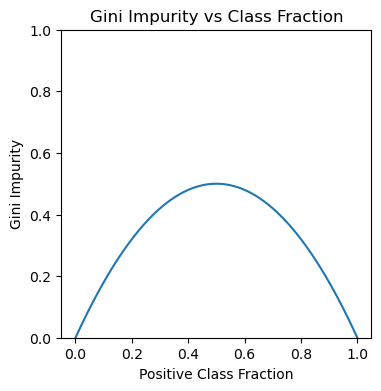

In [7]:
pos_class_f = np.linspace(0,1,1000) # positive class sample fraction
neg_class_f = 1 - pos_class_f
gini_impurity = 1 - pos_class_f**2 - neg_class_f**2 # Formula for calculation of Gini Impurity
plt.plot(pos_class_f, gini_impurity)
plt.title("Gini Impurity vs Class Fraction")
plt.xlabel("Positive Class Fraction")
plt.ylim([0,1])
plt.ylabel("Gini Impurity")
plt.show()

In [8]:
## Writing a function to calculate Gini Impurity

def gini_impurity(labels):
    if len(labels)==0:
        return 0
    n_labels, n_counts = np.unique(labels, return_counts = True)
    fractions = n_counts/np.sum(n_counts)
    return 1 - np.sum(fractions**2)

Visualizing Entropy for a Binary Dataset with varying number of positive samples

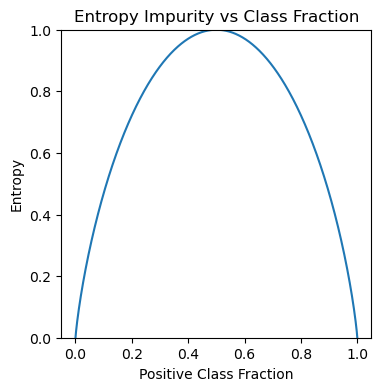

In [9]:
pos_class_f = np.linspace(0,1,1000) # positive class sample fraction
neg_class_f = 1 - pos_class_f
entropy = -1*(pos_class_f*np.log2(pos_class_f+1e-5) + neg_class_f*np.log2(neg_class_f+1e-5))
plt.plot(pos_class_f, entropy)
plt.title("Entropy Impurity vs Class Fraction")
plt.xlabel("Positive Class Fraction")
plt.ylim([0,1])
plt.ylabel("Entropy")
plt.show()

In [10]:
## Writing a function to calculate Entropy

def entropy(labels):
    if len(labels)==0:
        return 0
    n_labels, n_counts = np.unique(labels, return_counts = True)
    fractions = n_counts/np.sum(n_counts)
    return np.sum(-1*(fractions*np.log2(fractions)))

In [11]:
## Creating a common function to calculate the weighted impurity of the children nodes after a split
def weighted_impurity(groups, criterion = "gini"):
    criterion_dict = {"gini": gini_impurity,
                "entropy": entropy}
    n_total = sum([len(group) for group in groups])
    weighted_sum = 0
    for group in groups:
        weighted_sum += len(group)/n_total*criterion_dict[criterion](group)
    return weighted_sum

In [12]:
# Defining a function to split a dataset X, y into let and right nodes based on the feature index and feature value

def split_node(X, y, index, value):
    slicer = X[:, index]
    
    ## If feature is numerical type, then use a > or < comparision
    if value.dtype.kind in ["i", "f"]:
        bool_array = (slicer >= value)
    
    ## Else using assignment operator
    else:
        bool_array = (slicer == value)
    
    left_branch = [X[~bool_array, :], y[~bool_array]]
    right_branch = [X[bool_array, :], y[bool_array]]
    
    return left_branch, right_branch

In [13]:
## Defining a function to get the best split by taking the dataset and criteria function (gini or entropy)

def get_best_split(X, y, criterion = "gini"):
    criterion_dict = {"gini": gini_impurity, "entropy": entropy}    
    best_score = 1
    for index in np.arange(X.shape[1]):
        for value in np.unique(X[:, index]):
            groups = split_node(X, y, index, value)
            score = weighted_impurity([groups[0][1], groups[1][1]])
            if score < best_score:
                best_index, best_value, best_score, best_children = index, value, score, groups
            else:
                continue
    return {"index": best_index,
           "value": best_value,
           "children": best_children}

In [14]:
# Writing a function to get the major class in a leaf node

def get_leaf(labels):
    return np.bincount(labels).argmax()

Creating the final recursive function that uses all of the functions created before to perform the following tasks:

• It assigns a leaf node if one of two child nodes is empty

• It assigns a leaf node if the current branch depth exceeds the maximum depth allowed.

• It assigns a leaf node if the node does not contain sufficient samples required for a further split.

• Otherwise, it proceeds with a further split with the optimal splitting point.

In [15]:
def split(node, max_depth, min_samples, depth, criterion = "gini"):
    
    """
    In this function, we are passing a node which has been splitted using the get_best_split() function and therefore
    has two children nodes. The purpose of this function is to further split the children nodes unless they can't be
    split any further...and then convert the resulting children nodes into leaf nodes. The end result will be all 
    the children nodes as leaf nodes. 
    
    The output will be the decision tree in the form of a dictionary, starting from the root node. All the nodes will
    be dict type with left and right branches.
    """
    
    criterion_dict = {"gini": gini_impurity, "entropy": entropy}
    left, right = node["children"]
    del (node["children"])
    if len(left[1]) == 0:
        node["right"] = get_leaf(right[1])
        return
    if len(right[1]) == 0:
        node["left"] = get_leaf(left[1])
        return
    if depth >= max_depth:
        left = get_leaf(left[1])
        right = get_leaf(right[1])
        return
    
    if len(left[1]) <= min_samples:
        node["left"] = get_leaf(left[1])
    else:
        result = get_best_split(left[0], left[1], criterion)
        result_left, result_right = result["children"]
        if len(result_left[1]) == 0:
            node["left"] = get_leaf(result_right[1])
        elif len(result_right[1]) == 0:
            node["left"] = get_leaf(result_left[1])
        else:
            node["left"] = result
            split(node["left"], max_depth, min_samples, depth + 1, criterion)
    
    if len(right[1]) <= min_samples:
        node["right"] = get_leaf(right[1])
    else:
        result = get_best_split(right[0], right[1], criterion)
        result_left, result_right = result["children"]
        if len(result_left[1]) == 0:
            node["right"] = get_leaf(result_right[1])
        elif len(result_right[1]) == 0:
            node["right"] = get_leaf(result_left[1])
        else:
            node["right"] = result
            split(node["right"], max_depth, min_samples, depth + 1, criterion)

In [16]:
## Creating a function to start the tree building using dataset provided 

def train_tree(X, y, max_depth, min_samples, criterion = "gini"):
    X = np.array(X)
    y = np.array(y)
    root = get_best_split(X, y, criterion)
    split(root, max_depth, min_samples, 1, criterion)
    return root

In [17]:
X_train = [['tech', 'professional'],
           ['fashion', 'student'],
           ['fashion', 'professional'],
           ['sports', 'student'],
           ['tech', 'student'],
           ['tech', 'retired'],
           ['sports', 'professional']]
y_train = [1, 0, 0, 0, 1, 0, 1]
tree = train_tree(X_train, y_train, 2, 2)

In [18]:
## Running another numerical example
>>> X_train_n = [[6, 7],
... [2, 4],
... [7, 2],
... [3, 6],
... [4, 7],
... [5, 2],
... [1, 6],
... [2, 0],
... [6, 3],
... [4, 1]]
>>> y_train_n = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

n_tree = train_tree(X_train_n, y_train_n, 3, 2)
n_tree

{'index': 1,
 'value': 4,
 'left': {'index': 0, 'value': 7, 'left': 1, 'right': 0},
 'right': {'index': 0, 'value': 2, 'left': 1, 'right': 0}}

Using the Decision Tree Class from sklearn

In [19]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train_n, y_train_n)

DecisionTreeClassifier()

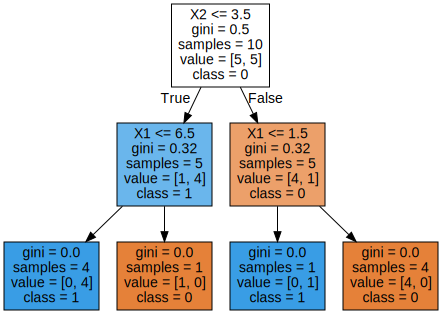

In [20]:
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(tree, "tree.dot", filled = True, feature_names = ["X1", "X2"],
               class_names = ["0", "1"])

Source.from_file("tree.dot")

In [21]:
dataset = pd.read_csv("train_300k.csv")

In [22]:
dataset.columns

Index(['Unnamed: 0', 'id', 'click', 'hour', 'C1', 'banner_pos', 'site_id',
       'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category',
       'device_id', 'device_ip', 'device_model', 'device_type',
       'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21'],
      dtype='object')

In [23]:
Y = dataset["click"]
X = dataset.drop(['id', 'click', 'hour', 'device_id', 'device_ip'], axis = 1)

In [24]:
## Taking the first 90% of datapoints as training data and the rest of datapoints as testing data

train_size = int(0.9*len(X))
X_train, y_train = X.iloc[:train_size, :], Y.iloc[:train_size]
X_test, y_test = X.iloc[train_size:, :], Y.iloc[train_size:]

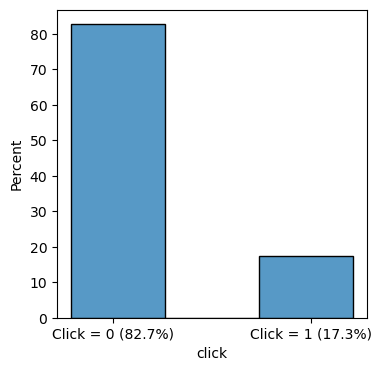

In [25]:
import seaborn as sns
ax = sns.histplot(y_train, bins = 3, stat = "percent")
click_counts = np.unique(y_train, return_counts = True)[1]
ax.set(xticks = [0.15, 0.85], xticklabels = [f"Click = 0 ({click_counts[0]/np.sum(click_counts)*100:.1f}%)", 
                                            f"Click = 1 ({click_counts[1]/np.sum(click_counts)*100:.1f}%)"])
plt.show()

From the above plot, we can see that the classes are imbalanced

In [26]:
## Using One Hot Encoder to transform all the categorical features into binary features

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown= "ignore")
X_train = ohe.fit_transform(X_train)

In [27]:
# One Hot Encoding the test dataset
X_test = ohe.transform(X_test)

In [25]:
## Using the Decision Tree Classifier to model the data
## Using Grid Search CV for hyperparameter tuning

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dtc = DecisionTreeClassifier(min_samples_split=30, random_state=42)
param_grid = {"max_depth": [3, 10, None]}
gcv = GridSearchCV(estimator=dtc, param_grid=param_grid, n_jobs = -1, cv = 3, verbose = 2, scoring = "roc_auc")

## Using Area Under the ROC curve as scoring parameter since the classes are imbalanced
gcv.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(min_samples_split=30,
                                              random_state=42),
             n_jobs=-1, param_grid={'max_depth': [3, 10, None]},
             scoring='roc_auc', verbose=2)

In [26]:
gcv.best_params_

{'max_depth': 10}

In [27]:
best_dtc = gcv.best_estimator_

In [36]:
## Evaluating the above model on training and testing dataset using AUC_ROC
from sklearn.metrics import roc_auc_score
train_prob = best_dtc.predict_proba(X_train)
test_prob = best_dtc.predict_proba(X_test)
train_score = roc_auc_score(y_true = y_train.values, y_score = train_prob[:, 1])
test_score = roc_auc_score(y_test.values, test_prob[:, 1])
print(f"ROC_AUC for training dataset = {train_score}\nROC_AUC for test dataset = {test_score}")

In [28]:
## Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier(n_estimators=5, min_samples_split=30, n_jobs=-1)
rfc.fit(X_train, y_train)
rfc_score = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])

In [29]:
rfc_score

0.72722838954081

In [ ]:
param_grid = {"max_depth": [3, 10, None]}
grid_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv = 3, n_jobs = -1, scoring = "roc_auc", verbose = 5)
grid_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [ ]:
best_rfc = grid_rfc.best_estimator_
rfc_pred_test = best_rfc.predict_proba(X_test)[:, 1]
print(f"ROC_AUC of Random Foret Classifier on the test dataset is: {roc_auc_score(y_test, rfc_pred_test)})

Using Gradient Boosting

In [1]:
import xgboost as xgb

In [29]:
boosted = xgb.XGBClassifier(n_estimators = 1000, learning_rate = 0.1, max_depth = 10)
boosted.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [37]:
boosted_pred = boosted.predict_proba(X_test)
## Testing the roc_auc score for the boosted model
print(f"The roc auc score for boosted model is {roc_auc_score(y_test, boosted_pred[:, 1])}")

The roc auc score for boosted model is 0.7705554461180284


THE XGBoost algorithm has the highest ROC AUC score of 0.77